# Face Classification and Recognition using Dimension Reduction Techniques

This notebook implements various dimension reduction techniques for face classification:
- PCA (Eigenfaces)
- LDA (Fisherfaces)
- Centroid classification
- CCA (Canonical Correlation Analysis)

Based on: "Applications of Digital Signal Processing - Face Categorization & Recognition"  
University of Patras, Department of Computer Engineering & Informatics

## Import Libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import CCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.manifold import TSNE
import seaborn as sns
import warnings

# Create results directory for outputs
RESULTS_DIR = "classification_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

## FaceClassifier Class

Main class for face classification experiments using various dimension reduction techniques.

In [2]:
class FaceClassifier:
    """
    Main class for face classification experiments using various
    dimension reduction techniques as described in the course material.
    """

    def __init__(self, splits_file="splits.json"):
        """
        Initialize the classifier with dataset splits

        Parameters:
        -----------
        splits_file: str
            Path to the JSON file containing dataset splits
        """
        print("Initializing face classifier...")
        print(f"Working directory: {os.getcwd()}")
        print(f"Directory contents: {os.listdir()}")

        # Load dataset splits
        with open(splits_file, "r") as f:
            self.splits = json.load(f)

        # Load and preprocess data
        self.X_train, self.y_train = self._load_set("train")
        self.X_test, self.y_test = self._load_set("test")

        # Encode labels
        self.le = LabelEncoder().fit(self.y_train)
        self.y_train_enc = self.le.transform(self.y_train).reshape(-1, 1)
        self.y_test_enc = self.le.transform(self.y_test).reshape(-1, 1)

        # Center data
        self.mean_face = self.X_train.mean(axis=0)
        self.X_train_centered = self.X_train - self.mean_face
        self.X_test_centered = self.X_test - self.mean_face

        # Calculate image dimensions from the first image
        first_img = Image.open(self.splits["train"][0]["path"])
        self.img_width, self.img_height = first_img.size

        # Dictionary to store classification results
        self.results = {}

        print(f"Data loaded: {self.X_train.shape[0]} training samples, {self.X_test.shape[0]} test samples")
        print(f"Classes: {list(self.le.classes_)}")
        print(f"Image dimensions: {self.img_width}x{self.img_height}")

    def _load_set(self, key):
        """
        Load and prepare dataset (train or test)

        Parameters:
        -----------
        key: str
            Either "train" or "test"

        Returns:
        --------
        X: numpy.ndarray
            Image data matrix (n_samples x n_features)
        y: numpy.ndarray
            Class labels
        """
        X, y = [], []
        for e in self.splits[key]:
            img = np.array(Image.open(e["path"]), dtype=float).flatten()
            X.append(img)
            y.append(e["label"])
        return np.vstack(X), np.array(y)

## PCA Method (Eigenfaces)

Apply Principal Component Analysis for dimension reduction and face classification.

In [3]:
# Add PCA method to FaceClassifier
def apply_pca(self, n_components=20, optimize=False):
    """
    Apply PCA dimension reduction (Eigenfaces) and 1-NN classification

    Parameters:
    -----------
    n_components: int
        Number of principal components to use
    optimize: bool
        Whether to optimize the number of components using cross-validation

    Returns:
    --------
    pred: numpy.ndarray
        Predicted labels for the test set
    """
    print(f"\n{'='*50}\nRunning PCA (Eigenfaces) with {n_components} components...")

    if optimize:
        # Find optimal number of components using cross-validation
        components_range = range(5, min(50, self.X_train.shape[0]), 5)
        pca_scores = []

        for n_comp in components_range:
            pca = PCA(n_components=n_comp, svd_solver="randomized", whiten=True)
            Z_train = pca.fit_transform(self.X_train_centered)

            knn = KNeighborsClassifier(n_neighbors=1)
            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(knn, Z_train, self.y_train, cv=cv)

            pca_scores.append((n_comp, scores.mean(), scores.std()))
            print(f"  Components: {n_comp}, CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

        # Use optimal number of components
        n_components = max(pca_scores, key=lambda x: x[1])[0]
        print(f"Optimal number of PCA components: {n_components}")

    # Apply PCA with the selected number of components
    self.pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True)
    self.Z_train = self.pca.fit_transform(self.X_train_centered)
    self.Z_test = self.pca.transform(self.X_test_centered)

    # Train and predict with 1-NN
    self.knn_pca = KNeighborsClassifier(n_neighbors=1).fit(self.Z_train, self.y_train)
    self.pred_pca = self.knn_pca.predict(self.Z_test)

    # Calculate probability estimates for ROC curve (distance-based)
    proba = self.knn_pca.predict_proba(self.Z_test)

    # Evaluate and store results
    self._evaluate_method("PCA + 1-NN", self.pred_pca, proba)

    # Visualize eigenfaces
    self._visualize_eigenfaces(n_components)

    return self.pred_pca

# Add the method to the class
FaceClassifier.apply_pca = apply_pca

## LDA Method (Fisherfaces)

Apply Linear Discriminant Analysis for dimension reduction and face classification.

In [4]:
# Add LDA method to FaceClassifier
def apply_lda(self, n_components=1):
    """
    Apply LDA dimension reduction (Fisherfaces) and 1-NN classification

    LDA maximizes the ratio of between-class variance to within-class variance,
    creating a discriminative feature space for classification as described
    in Fisher's Linear Discriminant Analysis.

    Parameters:
    -----------
    n_components: int
        Number of LDA components to use

    Returns:
    --------
    pred: numpy.ndarray
        Predicted labels for the test set
    """
    print(f"\n{'='*50}\nRunning LDA (Fisherfaces) with {n_components} components...")

    # Apply LDA
    self.lda = LinearDiscriminantAnalysis(n_components=n_components)
    self.L_train = self.lda.fit_transform(self.X_train_centered, self.y_train)
    self.L_test = self.lda.transform(self.X_test_centered)

    # Train and predict with 1-NN
    self.knn_lda = KNeighborsClassifier(n_neighbors=1).fit(self.L_train, self.y_train)
    self.pred_lda = self.knn_lda.predict(self.L_test)

    # Calculate probability estimates for ROC curve
    proba = self.knn_lda.predict_proba(self.L_test)

    # Evaluate and store results
    self._evaluate_method("LDA + 1-NN", self.pred_lda, proba)

    # Visualize fisherface
    self._visualize_fisherface()

    return self.pred_lda

# Add the method to the class
FaceClassifier.apply_lda = apply_lda

## Centroid Method

Apply Centroid classifier for face classification.

In [5]:
# Add Centroid method to FaceClassifier
def apply_centroid(self):
    """
    Apply Centroid classifier (calculating class centroids and
    assigning test samples to the nearest centroid class)

    Returns:
    --------
    pred: numpy.ndarray
        Predicted labels for the test set
    """
    print(f"\n{'='*50}\nRunning Centroid classifier...")

    # Calculate class centroids
    classes = np.unique(self.y_train)
    self.centroids = {}

    for class_label in classes:
        self.centroids[class_label] = self.X_train_centered[self.y_train == class_label].mean(axis=0)

    # Make predictions using nearest centroid
    self.pred_centroid = []
    proba = np.zeros((len(self.y_test), len(classes)))

    for i, x in enumerate(self.X_test_centered):
        distances = {}
        for label, centroid in self.centroids.items():
            distances[label] = np.linalg.norm(x - centroid)

        # Get the nearest class
        nearest_class = min(distances, key=distances.get)
        self.pred_centroid.append(nearest_class)

        # Calculate simple probability estimates based on distance
        total_inv_dist = sum(1/d for d in distances.values())
        for j, label in enumerate(classes):
            proba[i, j] = (1/distances[label]) / total_inv_dist

    self.pred_centroid = np.array(self.pred_centroid)

    # Evaluate and store results
    self._evaluate_method("Centroid", self.pred_centroid, proba)

    # Visualize mean faces (centroids)
    self._visualize_centroids()

    return self.pred_centroid

# Add the method to the class
FaceClassifier.apply_centroid = apply_centroid

## CCA Method

Apply Canonical Correlation Analysis for dimension reduction and face classification.

In [6]:
# Add CCA method to FaceClassifier
def apply_cca(self, n_components=1):
    """
    Apply CCA dimension reduction and 1-NN classification

    CCA finds transformations that maximize the correlation between
    projected vectors of two datasets (in this case, face images and labels).

    Parameters:
    -----------
    n_components: int
        Number of canonical components to use

    Returns:
    --------
    pred: numpy.ndarray
        Predicted labels for the test set
    """
    print(f"\n{'='*50}\nRunning CCA with {n_components} components...")

    # Apply CCA with regularization
    self.cca = CCA(n_components=n_components, scale=True)
    self.U_train, _ = self.cca.fit_transform(self.X_train_centered, self.y_train_enc)
    self.U_test, _ = self.cca.transform(self.X_test_centered, self.y_test_enc)
    
    # Normalize CCA projections to prevent extreme values
    # Get min/max for scaling from training data
    u_min = np.min(self.U_train)
    u_max = np.max(self.U_train)
    
    # Apply scaling to both train and test data to range [-1, 1]
    if u_max > u_min:  # Avoid division by zero
        self.U_train_normalized = 2 * (self.U_train - u_min) / (u_max - u_min) - 1
        self.U_test_normalized = 2 * (self.U_test - u_min) / (u_max - u_min) - 1
    else:
        self.U_train_normalized = self.U_train
        self.U_test_normalized = self.U_test
    
    # Use normalized projections for classification
    self.knn_cca = KNeighborsClassifier(n_neighbors=1).fit(self.U_train_normalized, self.y_train)
    self.pred_cca = self.knn_cca.predict(self.U_test_normalized)
    
    # Calculate probability estimates for ROC curve
    proba = self.knn_cca.predict_proba(self.U_test_normalized)
    
    # Evaluate and store results
    self._evaluate_method("CCA + 1-NN", self.pred_cca, proba)
    
    # Visualize canonical variate
    self._visualize_canonical_variate()
    
    return self.pred_cca

# Add the method to the class
FaceClassifier.apply_cca = apply_cca

## Evaluation Methods

Methods for evaluating the performance of different classification approaches.

In [7]:
# Add evaluation methods to FaceClassifier
def _evaluate_method(self, method_name, predictions, probabilities=None):
    """
    Evaluate classification performance and store results

    Parameters:
    -----------
    method_name: str
        Name of the classification method
    predictions: numpy.ndarray
        Predicted class labels
    probabilities: numpy.ndarray
        Class probabilities (for ROC curves)
    """
    # Calculate accuracy
    accuracy = accuracy_score(self.y_test, predictions)

    # Calculate confusion matrix
    cm = confusion_matrix(self.y_test, predictions, labels=self.le.classes_)

    # Generate classification report
    report = classification_report(self.y_test, predictions, target_names=self.le.classes_)

    # Store results
    self.results[method_name] = {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': predictions
    }

    if probabilities is not None:
        self.results[method_name]['probabilities'] = probabilities

    # Print results
    print(f"\n=== {method_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)

    # Analyze misclassified samples
    self._analyze_errors(predictions, method_name)

    # Plot and save confusion matrix
    self._plot_confusion_matrix(cm, method_name)

def _analyze_errors(self, predictions, method_name):
    """
    Analyze misclassified samples

    Parameters:
    -----------
    predictions: numpy.ndarray
        Predicted class labels
    method_name: str
        Name of the classification method
    """
    misclassified_indices = np.where(predictions != self.y_test)[0]
    print(f"\nAnalysis of {len(misclassified_indices)} misclassified samples for {method_name}:")

    # Group by actual and predicted class
    error_groups = {}
    for idx in misclassified_indices:
        true_label = self.y_test[idx]
        pred_label = predictions[idx]
        key = f"{true_label} → {pred_label}"
        if key not in error_groups:
            error_groups[key] = []
        error_groups[key].append(idx)

    # Print error statistics
    for error_type, indices in error_groups.items():
        print(f"  {error_type}: {len(indices)} samples ({len(indices)/len(misclassified_indices)*100:.1f}%)")

def _plot_confusion_matrix(self, cm, method_name):
    """
    Plot and save confusion matrix

    Parameters:
    -----------
    cm: numpy.ndarray
        Confusion matrix
    method_name: str
        Name of the classification method
    """
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.le.classes_)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax)
    plt.title(f"{method_name} - Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/{method_name.replace(' ', '_')}_confusion.png")
    plt.close()

# Add the methods to the class
FaceClassifier._evaluate_method = _evaluate_method
FaceClassifier._analyze_errors = _analyze_errors
FaceClassifier._plot_confusion_matrix = _plot_confusion_matrix

## Visualization Methods

Methods for visualizing the results of the different techniques.

In [8]:
# Add visualization methods to FaceClassifier
def _visualize_eigenfaces(self, n_components):
    """
    Visualize PCA eigenfaces (top 10 components)

    Parameters:
    -----------
    n_components: int
        Number of PCA components
    """
    # Extract eigenfaces from PCA components
    n_to_show = min(10, n_components)
    eigs = self.pca.components_.reshape((n_components, self.img_height, self.img_width))

    # Create and save visualization
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat[:n_to_show]):
        ax.imshow(eigs[i], cmap="gray")
        ax.set_title(f"Eigenface {i+1}")
        ax.axis("off")
    plt.suptitle("PCA: Top 10 Eigenfaces")
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/eigenfaces.png")
    plt.show()

def _visualize_fisherface(self):
    """
    Visualize LDA Fisherface
    """
    fisherface = self.lda.scalings_[:, 0].reshape((self.img_height, self.img_width))
    plt.figure(figsize=(6, 6))
    plt.imshow(fisherface, cmap="gray")
    plt.title("LDA Fisherface")
    plt.axis("off")
    plt.savefig(f"{RESULTS_DIR}/fisherface.png")
    plt.show()

def _visualize_centroids(self):
    """
    Visualize class centroids (mean faces)
    """
    fig, axes = plt.subplots(1, len(self.centroids), figsize=(4*len(self.centroids), 4))

    for i, (label, centroid) in enumerate(self.centroids.items()):
        mean_face = (centroid + self.mean_face).reshape((self.img_height, self.img_width))
        axes[i].imshow(mean_face, cmap="gray")
        axes[i].set_title(f"Mean {label.capitalize()} Face")
        axes[i].axis("off")

    plt.suptitle("Class Centroids")
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/centroids.png")
    plt.show()

def _visualize_canonical_variate(self):
    """
    Visualize CCA canonical variate
    """
    canon_var = self.cca.x_weights_[:, 0].reshape((self.img_height, self.img_width))
    plt.figure(figsize=(6, 6))
    plt.imshow(canon_var, cmap="gray")
    plt.title("CCA: Canonical Variate")
    plt.axis("off")
    plt.savefig(f"{RESULTS_DIR}/canonical_variate.png")
    plt.show()

# Add the methods to the class
FaceClassifier._visualize_eigenfaces = _visualize_eigenfaces
FaceClassifier._visualize_fisherface = _visualize_fisherface
FaceClassifier._visualize_centroids = _visualize_centroids
FaceClassifier._visualize_canonical_variate = _visualize_canonical_variate

## Data Distribution Visualization Methods

Methods for visualizing data distributions using different techniques.

In [9]:
# Add data distribution visualization methods to FaceClassifier
def visualize_data_distribution(self, method=None):
    """
    Visualize data distribution using t-SNE or KDE plots for 1D data

    Parameters:
    -----------
    method: str
        Method to use for feature extraction prior to visualization
        Options: "original", "pca", "lda", "cca" (default: original data)
    """
    print(f"\n{'='*50}\nVisualizing data distribution with {method if method else 'original'} features...")

    # Prepare data based on selected method
    if method == "pca" and hasattr(self, 'Z_train') and hasattr(self, 'Z_test'):
        X = np.vstack([self.Z_train, self.Z_test])
        title = "PCA Features"
        is_1d = False
    elif method == "lda" and hasattr(self, 'L_train') and hasattr(self, 'L_test'):
        X = np.vstack([self.L_train, self.L_test])
        title = "LDA Features"
        is_1d = X.shape[1] == 1  # Check if LDA produced 1D data
    elif method == "cca" and hasattr(self, 'U_train_normalized') and hasattr(self, 'U_test_normalized'):
        X = np.vstack([self.U_train_normalized, self.U_test_normalized])
        title = "CCA Features (Normalized)"
        is_1d = X.shape[1] == 1  # Check if CCA produced 1D data
    else:
        # Use original centered data
        X = np.vstack([self.X_train_centered, self.X_test_centered])
        title = "Original Features"
        is_1d = False

    y = np.concatenate([self.y_train, self.y_test])
    is_train = np.array(['train']*len(self.y_train) + ['test']*len(self.y_test))

    # Create visualization based on data dimensionality
    if is_1d:
        print(f"Using KDE visualization for 1D {title}...")
        self._visualize_1d_data(X, y, is_train, title)
    else:
        print(f"Applying t-SNE on {title}...")
        self._visualize_with_tsne(X, y, is_train, title)

def _visualize_1d_data(self, X, y, is_train, title):
    """
    Create KDE visualization for 1D data with robust error handling

    Parameters:
    -----------
    X: numpy.ndarray
        1D feature data
    y: numpy.ndarray
        Class labels
    is_train: numpy.ndarray
        Indicates whether samples are from training or test set
    title: str
        Title for the visualization
    """
    try:
        # Flatten X if it's a 2D array with 1 column
        if X.ndim > 1:
            X = X.flatten()

        # Check for and handle NaN or Inf values
        if np.isnan(X).any() or np.isinf(X).any():
            print("Warning: Data contains NaN or Inf values. Removing problematic samples.")
            valid_idx = ~(np.isnan(X) | np.isinf(X))
            X = X[valid_idx]
            y = y[valid_idx]
            is_train = is_train[valid_idx]

        # Handle extreme outliers by clipping to percentiles
        lower_bound = np.percentile(X, 1)
        upper_bound = np.percentile(X, 99)
        X_clipped = np.clip(X, lower_bound, upper_bound)

        # Create DataFrame for plotting
        df = pd.DataFrame({
            'feature': X_clipped,
            'class': y,
            'set': is_train
        })

        # Plot KDE separately for each class and set
        plt.figure(figsize=(12, 6))

        unique_classes = np.unique(y)
        for idx, class_name in enumerate(unique_classes):
            for set_type in ['train', 'test']:
                subset = df[(df['class'] == class_name) & (df['set'] == set_type)]
                if len(subset) > 0:
                    sns.kdeplot(
                        data=subset,
                        x='feature',
                        label=f"{class_name} ({set_type})",
                        fill=True,
                        alpha=0.3,
                        linewidth=2,
                        common_norm=False
                    )

        plt.title(f"Distribution of {title}")
        plt.xlabel("Feature Value")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{RESULTS_DIR}/kde_{title.replace(' ', '_')}.png")
        plt.show()

    except Exception as e:
        # Fallback to simple scatter plot if KDE fails
        warnings.warn(f"KDE plot failed with error: {str(e)}. Using scatter plot instead.")
        self._fallback_1d_visualization(X, y, is_train, title)

def _fallback_1d_visualization(self, X, y, is_train, title):
    """
    Create a simple scatter plot as fallback for 1D data visualization

    Parameters:
    -----------
    X: numpy.ndarray
        1D feature data
    y: numpy.ndarray
        Class labels
    is_train: numpy.ndarray
        Indicates whether samples are from training or test set
    title: str
        Title for the visualization
    """
    try:
        # Flatten X if needed
        if X.ndim > 1:
            X = X.flatten()

        # Remove any invalid values
        valid_idx = ~(np.isnan(X) | np.isinf(X))
        X = X[valid_idx]
        y = y[valid_idx]
        is_train = is_train[valid_idx]

        # Handle extreme outliers
        q1, q3 = np.percentile(X, [1, 99])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        X_clipped = np.clip(X, lower_bound, upper_bound)

        # Create figure
        plt.figure(figsize=(12, 6))

        # Jitter for y-axis to show distribution
        jitter = np.random.normal(0, 0.05, size=len(X_clipped))

        # Plot each class and set type
        unique_classes = np.unique(y)
        for i, class_name in enumerate(unique_classes):
            for j, set_type in enumerate(['train', 'test']):
                mask = (y == class_name) & (is_train == set_type)
                plt.scatter(
                    X_clipped[mask],
                    i + jitter[mask],
                    label=f"{class_name} ({set_type})",
                    alpha=0.7,
                    s=20,
                    marker='o' if set_type == 'train' else 'x'
                )

        plt.yticks(range(len(unique_classes)), unique_classes)
        plt.title(f"Distribution of {title}")
        plt.xlabel("Feature Value")
        plt.ylabel("Class")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{RESULTS_DIR}/scatter_{title.replace(' ', '_')}.png")
        plt.show()

    except Exception as e:
        # If all else fails, report the error and don't produce a visualization
        warnings.warn(f"All visualization attempts failed for {title}. Error: {str(e)}")
        print(f"ERROR: Could not visualize {title}. The data may have extreme values or other issues.")
        print(f"Data statistics: min={np.min(X)}, max={np.max(X)}, mean={np.mean(X)}, std={np.std(X)}")

def _visualize_with_tsne(self, X, y, is_train, title):
    """
    Create t-SNE visualization for multi-dimensional data

    Parameters:
    -----------
    X: numpy.ndarray
        Multi-dimensional feature data
    y: numpy.ndarray
        Class labels
    is_train: numpy.ndarray
        Indicates whether samples are from training or test set
    title: str
        Title for the visualization
    """
    try:
        # Scale the data for better t-SNE results
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply t-SNE with careful perplexity setting
        perplexity = min(30, max(5, len(X_scaled) // 10))
        tsne = TSNE(
            n_components=2,
            random_state=42,
            perplexity=perplexity,
            n_iter=1000,
            init='pca'
        )
        X_tsne = tsne.fit_transform(X_scaled)

        # Create DataFrame for easy plotting
        df = pd.DataFrame({
            'x': X_tsne[:, 0],
            'y': X_tsne[:, 1],
            'class': y,
            'set': is_train
        })

        # Plot by class
        plt.figure(figsize=(12, 10))
        sns.scatterplot(data=df, x='x', y='y', hue='class', style='set', palette='viridis')
        plt.title(f"t-SNE Visualization - {title}")
        plt.tight_layout()
        plt.savefig(f"{RESULTS_DIR}/tsne_{title.replace(' ', '_')}.png")
        plt.show()

    except Exception as e:
        warnings.warn(f"t-SNE visualization failed: {str(e)}")
        print(f"ERROR: Could not create t-SNE visualization for {title}.")

# Add the methods to the class
FaceClassifier.visualize_data_distribution = visualize_data_distribution
FaceClassifier._visualize_1d_data = _visualize_1d_data
FaceClassifier._fallback_1d_visualization = _fallback_1d_visualization
FaceClassifier._visualize_with_tsne = _visualize_with_tsne

## ROC Curves and Results Summary

Methods for plotting ROC curves and summarizing results.

In [10]:
# Add ROC and summary methods to FaceClassifier
def plot_roc_curves(self):
    """
    Plot ROC curves for all methods that provide probability estimates
    """
    print(f"\n{'='*50}\nPlotting ROC curves...")

    plt.figure(figsize=(10, 8))

    for method_name, result in self.results.items():
        if 'probabilities' in result:
            # For binary classification, get probability of the positive class
            positive_class_idx = np.where(self.le.classes_ == 'male')[0][0]
            y_score = result['probabilities'][:, positive_class_idx]

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(self.y_test == 'male', y_score)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, label=f'{method_name} (AUC = {roc_auc:.3f})')

    # Plot random classifier line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.savefig(f"{RESULTS_DIR}/roc_comparison.png")
    plt.show()

def summarize_results(self):
    """
    Summarize classification results for all methods
    """
    print(f"\n{'='*50}")
    print("SUMMARY OF CLASSIFICATION RESULTS")
    print(f"{'='*50}")

    # Sort methods by accuracy
    sorted_methods = sorted(
        [(name, result['accuracy']) for name, result in self.results.items()],
        key=lambda x: x[1],
        reverse=True
    )

    # Print summary table
    print(f"{'Method':<15} | {'Accuracy':<10}")
    print("-"*28)

    for method, accuracy in sorted_methods:
        print(f"{method:<15} | {accuracy:.4f}")

    # Create a summary figure
    plt.figure(figsize=(10, 6))
    methods = [m[0] for m in sorted_methods]
    accuracies = [m[1] for m in sorted_methods]

    bars = plt.bar(methods, accuracies, color='skyblue')
    plt.ylim(0, 1.0)
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy by Method')
    plt.xticks(rotation=45, ha='right')

    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/accuracy_comparison.png")
    plt.show()

    # Save results to a JSON file
    results_summary = {name: {'accuracy': result['accuracy']}
                      for name, result in self.results.items()}

    with open(f"{RESULTS_DIR}/results_summary.json", 'w') as f:
        json.dump(results_summary, f, indent=4)

# Add the methods to the class
FaceClassifier.plot_roc_curves = plot_roc_curves
FaceClassifier.summarize_results = summarize_results

## Run Face Classification Experiments

Execute the main experiments with different classification methods.

Initializing face classifier...
Working directory: f:\OneDrive - University of Patras\CEID\10ο Εξάμηνο\ΕΦΑΡΜΟΓΕΣ ΨΗΦΙΑΚΗΣ ΕΠΕΞΕΡΓΑΣΙΑΣ ΣΗΜΑΤΩΝ\ASKISI 4\ADSP_4-LDA
Directory contents: ['ADSP_PCA_LDA_k_means_cor.pdf', 'classification_results', 'faces_dataset', 'face_classification.ipynb', 'face_classification.py', 'gender_map.json', 'make_splits.py', 'pipeline.py', 'report template.docx', 'splits.json', 'test_json_load.py']
Data loaded: 280 training samples, 120 test samples
Classes: ['female', 'male']
Image dimensions: 92x112

Visualizing data distribution with original features...
Applying t-SNE on Original Features...


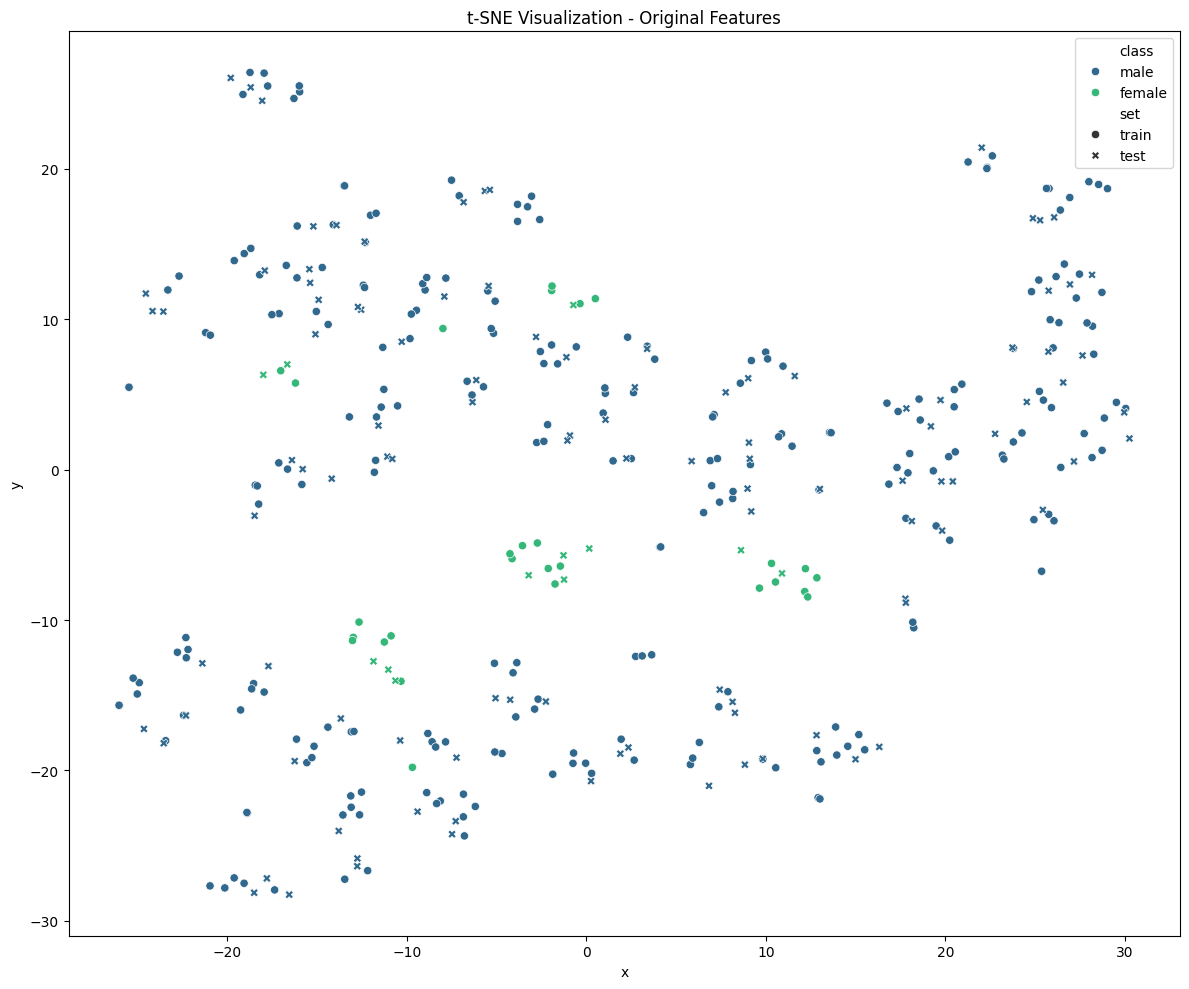

In [11]:
# Filter out specific scikit-learn warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Initialize face classifier
classifier = FaceClassifier(splits_file="splits.json")

# Visualize original data distribution
classifier.visualize_data_distribution()


Running PCA (Eigenfaces) with 20 components...
  Components: 5, CV Accuracy: 0.9714 ± 0.0182
  Components: 10, CV Accuracy: 0.9893 ± 0.0143
  Components: 15, CV Accuracy: 0.9857 ± 0.0134
  Components: 20, CV Accuracy: 0.9893 ± 0.0087
  Components: 25, CV Accuracy: 0.9893 ± 0.0143
  Components: 30, CV Accuracy: 0.9964 ± 0.0071
  Components: 35, CV Accuracy: 0.9964 ± 0.0071
  Components: 40, CV Accuracy: 0.9929 ± 0.0087
  Components: 45, CV Accuracy: 0.9821 ± 0.0277
Optimal number of PCA components: 30

=== PCA + 1-NN ===
Accuracy: 0.9917
Confusion Matrix:
[[ 11   1]
 [  0 108]]
Classification Report:
              precision    recall  f1-score   support

      female       1.00      0.92      0.96        12
        male       0.99      1.00      1.00       108

    accuracy                           0.99       120
   macro avg       1.00      0.96      0.98       120
weighted avg       0.99      0.99      0.99       120


Analysis of 1 misclassified samples for PCA + 1-NN:
  female → m

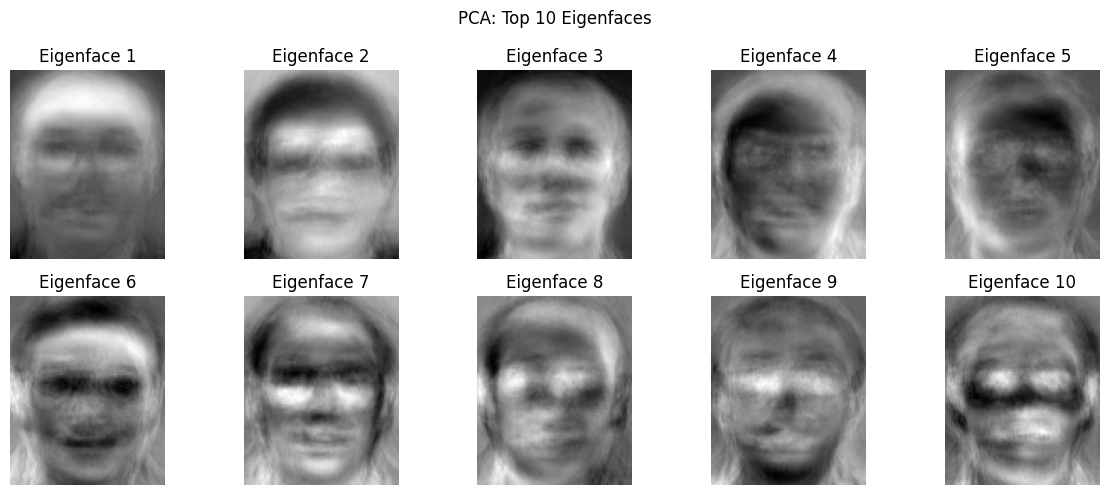

array(['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'female', 'female',
       'female', 'male', 'male', 'male', 'female', 'female', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female',
       'female', 'female', 'male', 'male', 'male', 'male', 'male', 'male',
       'female', 'female', 'female', 'male', 'male', 'male', 'male',
       '

In [12]:
# Apply PCA (Eigenfaces) method
classifier.apply_pca(n_components=20, optimize=True)


Running LDA (Fisherfaces) with 1 components...

=== LDA + 1-NN ===
Accuracy: 0.9500
Confusion Matrix:
[[  7   5]
 [  1 107]]
Classification Report:
              precision    recall  f1-score   support

      female       0.88      0.58      0.70        12
        male       0.96      0.99      0.97       108

    accuracy                           0.95       120
   macro avg       0.92      0.79      0.84       120
weighted avg       0.95      0.95      0.95       120


Analysis of 6 misclassified samples for LDA + 1-NN:
  female → male: 5 samples (83.3%)
  male → female: 1 samples (16.7%)


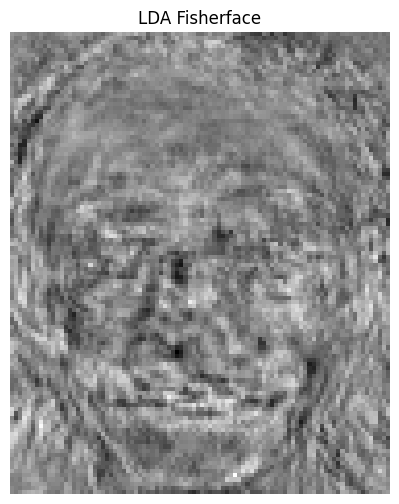

array(['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'female', 'female',
       'female', 'male', 'male', 'male', 'female', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'female', 'female',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male'

In [13]:
# Apply LDA (Fisherfaces) method
classifier.apply_lda(n_components=1)


Running Centroid classifier...

=== Centroid ===
Accuracy: 0.8583
Confusion Matrix:
[[10  2]
 [15 93]]
Classification Report:
              precision    recall  f1-score   support

      female       0.40      0.83      0.54        12
        male       0.98      0.86      0.92       108

    accuracy                           0.86       120
   macro avg       0.69      0.85      0.73       120
weighted avg       0.92      0.86      0.88       120


Analysis of 17 misclassified samples for Centroid:
  male → female: 15 samples (88.2%)
  female → male: 2 samples (11.8%)


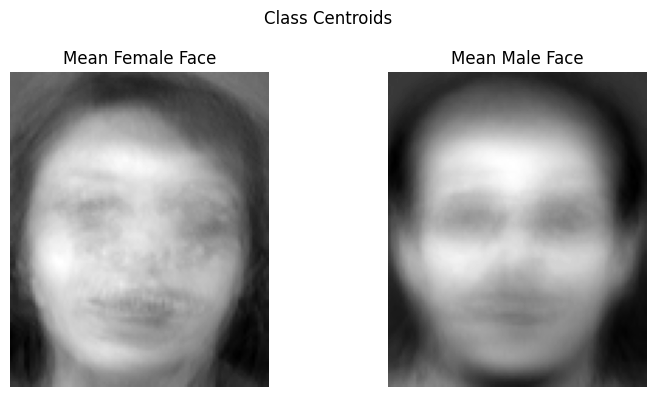

array(['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'female', 'male', 'female',
       'female', 'female', 'female', 'male', 'male', 'male', 'female',
       'female', 'female', 'male', 'male', 'male', 'female', 'female',
       'female', 'male', 'male', 'male', 'female', 'female', 'female',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'female', 'male', 'female', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female',
       'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'female', 'female', 'female', 'male', 'male', 'male',
       'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male',


In [14]:
# Apply Centroid classifier method
classifier.apply_centroid()


Running CCA with 1 components...

=== CCA + 1-NN ===
Accuracy: 0.9833
Confusion Matrix:
[[ 10   2]
 [  0 108]]
Classification Report:
              precision    recall  f1-score   support

      female       1.00      0.83      0.91        12
        male       0.98      1.00      0.99       108

    accuracy                           0.98       120
   macro avg       0.99      0.92      0.95       120
weighted avg       0.98      0.98      0.98       120


Analysis of 2 misclassified samples for CCA + 1-NN:
  female → male: 2 samples (100.0%)


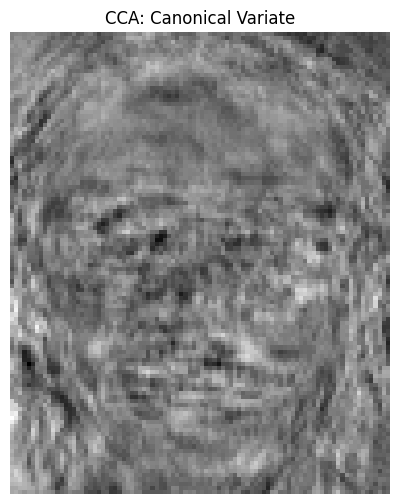

array(['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'female', 'female',
       'female', 'male', 'male', 'male', 'female', 'male', 'female',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female',
       'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'female', 'female', 'female', 'male', 'male', 'male', 'male',
       'ma

In [15]:
# Apply CCA method
classifier.apply_cca(n_components=1)

## Visualize Data Distributions

Visualize the data distributions after applying different dimension reduction techniques.


Visualizing data distribution with pca features...
Applying t-SNE on PCA Features...


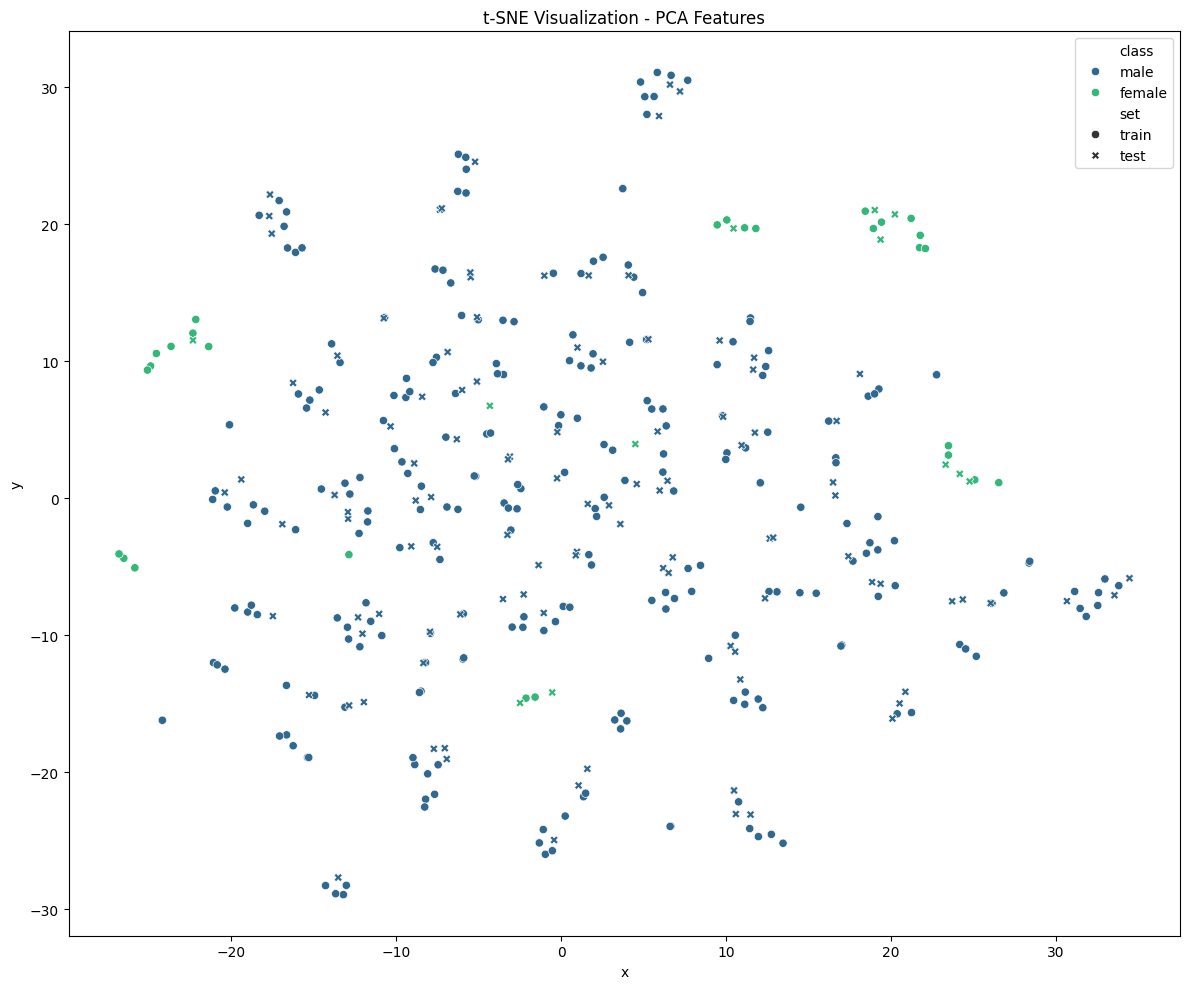

In [16]:
# Visualize data distributions after dimension reduction
classifier.visualize_data_distribution(method="pca")


Visualizing data distribution with lda features...
Using KDE visualization for 1D LDA Features...


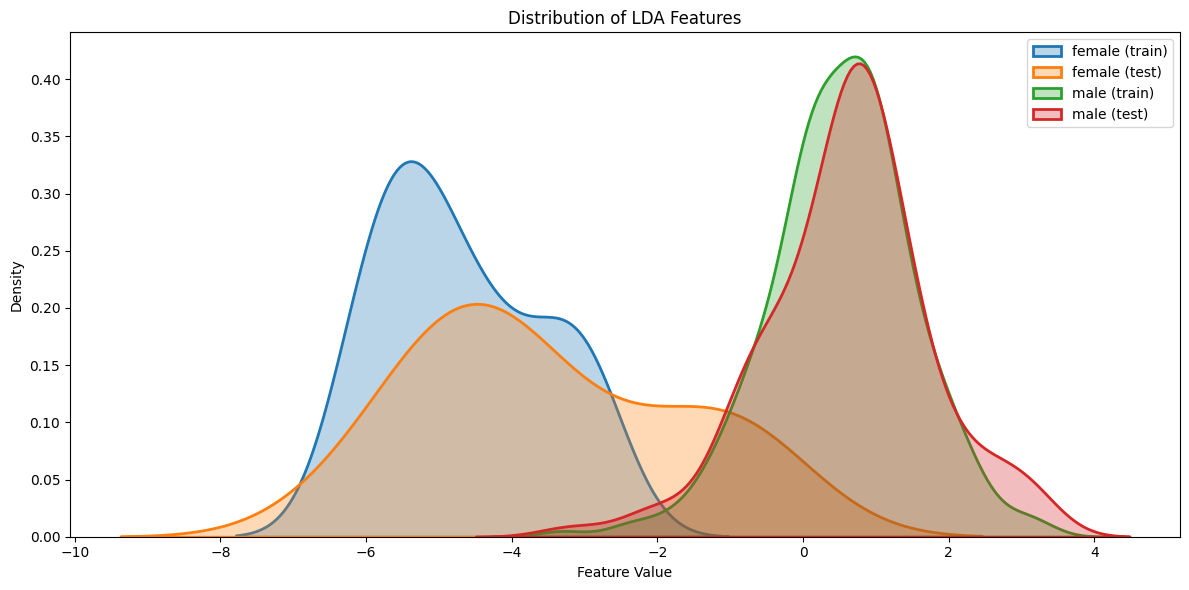

In [17]:
classifier.visualize_data_distribution(method="lda")


Visualizing data distribution with cca features...
Using KDE visualization for 1D CCA Features (Normalized)...


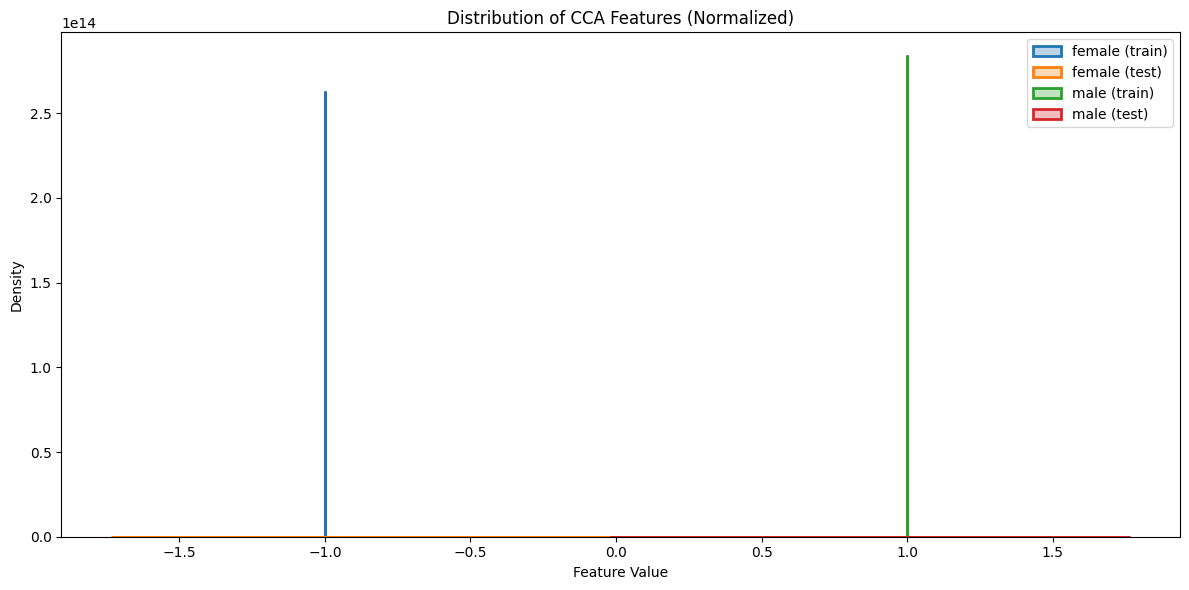

In [18]:
classifier.visualize_data_distribution(method="cca")

## ROC Curves and Results Summary

Plot ROC curves and summarize the results of all methods.


Plotting ROC curves...


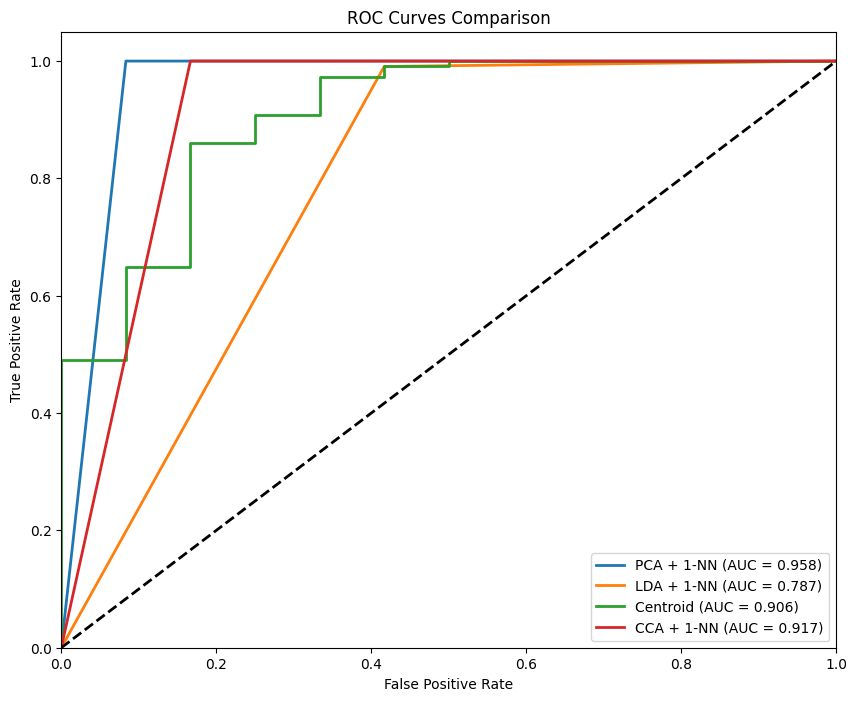

In [19]:
# Plot ROC curves
classifier.plot_roc_curves()


SUMMARY OF CLASSIFICATION RESULTS
Method          | Accuracy  
----------------------------
PCA + 1-NN      | 0.9917
CCA + 1-NN      | 0.9833
LDA + 1-NN      | 0.9500
Centroid        | 0.8583


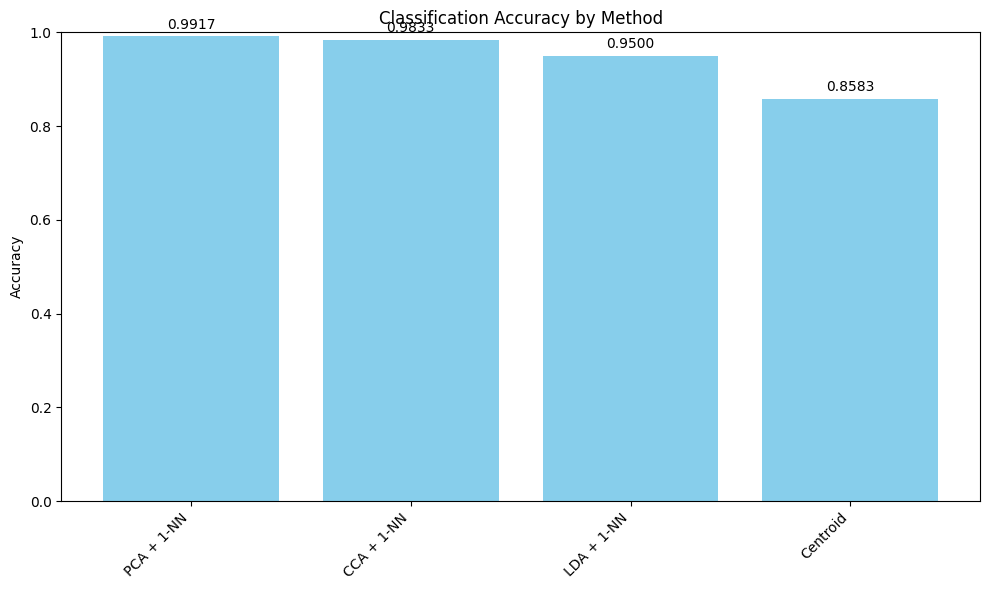


All results saved to classification_results/


In [20]:
# Summarize results
classifier.summarize_results()

print(f"\nAll results saved to {RESULTS_DIR}/")